## Modelling

In [ ]:
# Imports

#%tensorflow_version 2.x

# Keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import get_file
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.preprocessing import image, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# For AUC estimation and ROC plots
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## fasttext

In [ ]:
# Read word embeddings
embedding_matrix = np.genfromtxt('C:\\Users\\ddbor\\Downloads\\cw3_preprocessed\\cw3_preprocessed\\cw3_embeddingmatrix.txt') #loads the preprocessed data generate last week

# Read the padded text sequences. Uses numpy function that loads from a previously saved txt.
data = np.genfromtxt('C:\\Users\\ddbor\\Downloads\\cw3_preprocessed\\cw3_preprocessed\\cw3_padded.txt')
labels = np.genfromtxt('C:\\Users\\ddbor\\Downloads\\cw3_preprocessed\\cw3_preprocessed\\cw3_labels.txt')

In [ ]:
# Split into train and test
Xtrain, Xtest, ytrain, ytest = train_test_split(data, labels, test_size=0.2,
                                                    random_state=251082976, 
                                                    stratify = labels) #sampling fro within each class

#### Structure 1. Using Kim's Model

In [ ]:
# Filter sizes to use.
filter_sizes31 = (3,3,3,3) 

# Initialize.
graph_in31 = Input(shape=(88, 300)) # will keep the input layer without any connections
convs31 = []
avgs31 = []

# This for stacks the layers. Inside each for, we build the sequence of layer. The command "append" adds
# that to the "conv" variable, which is simply a stack of convolutions.
for fsz in filter_sizes31:
    conv = Conv1D(filters=32,
                  kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=2)(graph_in31) # Note the (graph_in). This means "put this layer AFTER the graph_in layer.
                         #max looking for the very best variable, 
    pool = MaxPooling1D(pool_size=fsz)(conv) # Put this layer AFTER the convolution just created.
    convs31.append(pool) # Append this to the convs object that saves the stack.
    
# Concatenate layers.
if len(filter_sizes31)>1:
    out = Concatenate()(convs31)
else:
    out = convs31[0]

graph31 = Model(inputs=graph_in31, outputs=out, name="graphModel")

graph31.summary()

In [ ]:
modelk31 = Sequential()
embedding_layerk31 = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

modelk31.add(embedding_layerk31)
modelk31.add(Dropout(0.6))
# Now we add our graph model
modelk31.add(graph31)

# Add a few layers

modelk31.add(Flatten())
modelk31.add(Dense(64, activation='relu'))
modelk31.add(Dropout(0.5))
modelk31.add(Dense(64, activation = 'relu'))
modelk31.add(Dropout(0.5))
modelk31.add(Dense(1))
modelk31.add(Dense(1, activation='sigmoid'))

# adam = Adam(clipnorm=.1)
modelk31.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
modelk31.fit(Xtrain, ytrain, validation_split=0.3, epochs=50, batch_size=32, verbose=1)

In [ ]:

loss31 = modelk31.history.history['loss']
val_loss31 = modelk31.history.history['val_loss']
epochs31 = range(1, len(loss31) + 1)
plt.figure(dpi=120)
plt.plot(epochs31, loss31, 'bo', label='Training loss')
plt.plot(epochs31, val_loss31, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
modelk31.fit(Xtrain, ytrain, validation_split=0.3, epochs=16, batch_size=32, verbose=1)

In [ ]:
# Cutting at point 16
loss31 = modelk31.history.history['loss']
val_loss31 = modelk31.history.history['val_loss']
epochs31 = range(1, len(loss31) + 1)
plt.figure(dpi=120)
plt.plot(epochs31, loss31, 'bo', label='Training loss')
plt.plot(epochs31, val_loss31, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

This model was using in the graph model fsz equal to 4 instead of 3

In [ ]:

loss31 = modelk31.history.history['loss']
val_loss31 = modelk31.history.history['val_loss']
epochs31 = range(1, len(loss31) + 1)
plt.figure(dpi=120)
plt.plot(epochs31, loss31, 'bo', label='Training loss')
plt.plot(epochs31, val_loss31, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#### Structure 2. Using Bidirectional and CNN

In [ ]:
model_ft1 = Sequential()
embedding_layerft1 = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

model_ft1.add(embedding_layerft1)
model_ft1.add(Dropout(0.5))

model_ft1.add(Bidirectional(GRU(64, return_sequences=True)))

model_ft1.add(Conv1D(filters=32,           # How many filters to calculate.
                 kernel_size=4,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))
model_ft1.add(Conv1D(filters=32,           # How many filters to calculate.
                 kernel_size=4,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))
model_ft1.add(GlobalMaxPool1D())

model_ft1.add(Dense(64, activation='relu'))
model_ft1.add(Dropout(0.5))
model_ft1.add(Dense(64, activation='relu'))
model_ft1.add(Dropout(0.5))
model_ft1.add(Dense(1, activation='sigmoid'))
model_ft1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_ft1.fit(Xtrain, ytrain, validation_split=0.3, epochs=50, batch_size=32, verbose=1)

In [ ]:
loss_ft1 = model_ft1.history.history['loss']
val_loss_ft1 = model_ft1.history.history['val_loss']
epochs_ft1 = range(1, len(loss_ft1) + 1)
plt.figure(dpi=120)
plt.plot(epochs_ft1, loss_ft1, 'bo', label='Training loss')
plt.plot(epochs_ft1, val_loss_ft1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model_ft1.fit(Xtrain, ytrain, validation_split=0.3, epochs=25, batch_size=32, verbose=1)

I decided to cut the model at 25

In [ ]:
loss_ft1 = model_ft1.history.history['loss']
val_loss_ft1 = model_ft1.history.history['val_loss']
epochs_ft1 = range(1, len(loss_ft1) + 1)
plt.figure(dpi=120)
plt.plot(epochs_ft1, loss_ft1, 'bo', label='Training loss')
plt.plot(epochs_ft1, val_loss_ft1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## GLOVE

In [ ]:
# Read word embeddings
embedding_glove = np.genfromtxt('C:\\Users\\ddbor\\Downloads\\glove_data\\glove_data\\glove_embeddingmatrix.txt') #loads the preprocessed data generate last week

# Read the padded text sequences. Uses numpy function that loads from a previously saved txt.
data_glove = np.genfromtxt('C:\\Users\\ddbor\\Downloads\\glove_data\\glove_data\\glove_padded.txt')
labels_glove = np.genfromtxt('C:\\Users\\ddbor\\Downloads\\glove_data\\glove_data\\glove_labels.txt')

In [ ]:
# Split into train and test
Xtraing, Xtestg, ytraing, ytestg = train_test_split(data_glove, labels_glove, test_size=0.2,
                                                    random_state=251082976, 
                                                    stratify = labels) #sampling

#### Structure1. Using Kim's Model (Same as applied in fasttex)

In [ ]:
filter_sizes312 = (3,3,3,3)

graph_in312 = Input(shape=(88, 300)) # will keep the input layer without any connections
convs312 = []
avgs312 = []


for fsz in filter_sizes312:
    conv = Conv1D(filters=32,
                  kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=2)(graph_in312) 
    pool = MaxPooling1D(pool_size=fsz)(conv) 
    convs312.append(pool)
    
# Concatenate layers.
if len(filter_sizes312)>1:
    out = Concatenate()(convs312)
else:
    out = convs312[0]

graph312 = Model(inputs=graph_in312, outputs=out, name="graphModel")

graph312.summary()

In [ ]:
modelk31g2 = Sequential()
embedding_layerk31g2 = Embedding(len(embedding_glove),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_glove],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights

modelk31g2.add(embedding_layerk31g2)
modelk31g2.add(Dropout(0.6))
# Now we add our graph model
modelk31g2.add(graph312)

# Add a few layers

modelk31g2.add(Flatten())
modelk31g2.add(Dense(64, activation='relu'))
modelk31g2.add(Dropout(0.5))
modelk31g2.add(Dense(64, activation = 'relu'))
modelk31g2.add(Dropout(0.5))
modelk31g2.add(Dense(1))
modelk31g2.add(Dense(1, activation='sigmoid'))

# adam = Adam(clipnorm=.1)
modelk31g2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

In [ ]:
modelk31g2.fit(Xtraing, ytraing, validation_split=0.3, epochs=20, batch_size=32, verbose=1)

In [ ]:
modelk31g2.summary()

In [ ]:
lossk31g2 = modelk31g2.history.history['loss']
valk31g2 = modelk31g2.history.history['val_loss']
epochsk31g2 = range(1, len(lossk31g2) + 1)
plt.figure(dpi=120)
plt.plot(epochsk31g2, lossk31g2, 'bo', label='Training loss')
plt.plot(epochsk31g2, valk31g2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
modelk31g2.summary()

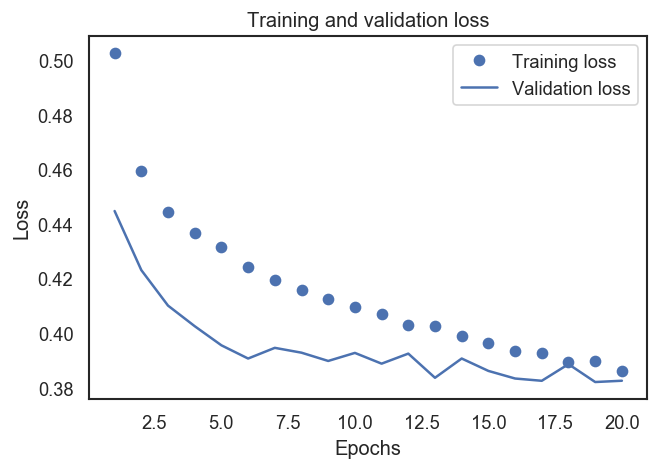

In [232]:
lossk31g2 = modelk31g2.history.history['loss']
valk31g2 = modelk31g2.history.history['val_loss']
epochsk31g2 = range(1, len(lossk31g2) + 1)
plt.figure(dpi=120)
plt.plot(epochsk31g2, lossk31g2, 'bo', label='Training loss')
plt.plot(epochsk31g2, valk31g2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Structure 2. Bidirectional and CNN


100 epoch where performed

In [ ]:
model_g1 = Sequential()
embedding_layerg1 = Embedding(len(embedding_glove),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_glove],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

model_g1.add(embedding_layerg1)
model_g1.add(Dropout(0.5))

model_g1.add(Bidirectional(GRU(64, return_sequences=True)))

model_g1.add(Conv1D(filters=32,           # How many filters to calculate.
                 kernel_size=4,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))
model_g1.add(Conv1D(filters=32,           # How many filters to calculate.
                 kernel_size=4,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))
model_g1.add(GlobalMaxPool1D())

model_g1.add(Dense(64, activation='relu'))
model_g1.add(Dropout(0.5))
model_g1.add(Dense(64, activation='relu'))
model_g1.add(Dropout(0.5))
model_g1.add(Dense(1, activation='sigmoid'))
model_g1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_g1.fit(Xtraing, ytraing, validation_split=0.3, epochs=20, batch_size=512, verbose=1)

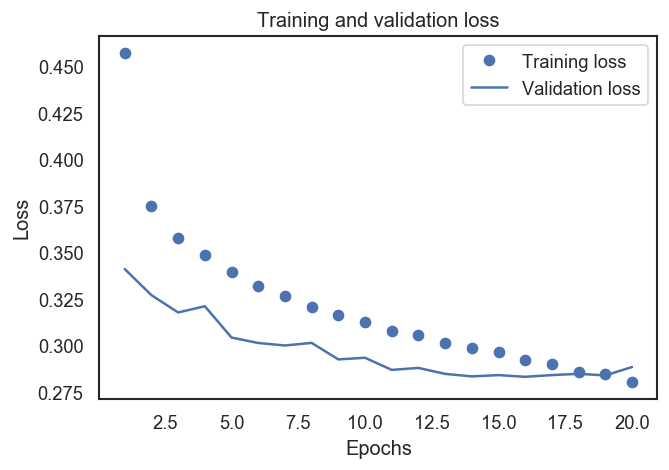

In [231]:
loss_g23 = model_g1.history.history['loss']
val_lossg23 = model_g1.history.history['val_loss']
epochs_g23 = range(1, len(loss_g23) + 1)
plt.figure(dpi=120)
plt.plot(epochs_g23, loss_g23, 'bo', label='Training loss')
plt.plot(epochs_g23, val_lossg23, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [230]:
sns.set_style("white")

In [ ]:
loss_g23 = model_g1.history.history['loss']
val_lossg23 = model_g1.history.history['val_loss']
epochs_g23 = range(1, len(loss_g23) + 1)
plt.figure(dpi=120)
plt.plot(epochs_g23, loss_g23, 'bo', label='Training loss')
plt.plot(epochs_g23, val_lossg23, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Calculating the metrics

1. Accuracy
2. AUCROC
3. Confusion Matrix

In [ ]:
scoreg = model_g1.evaluate(Xtestg, ytestg, verbose=1)
scoreg1 = modelk31g2.evaluate(Xtestg, ytestg, verbose=1)
scoreft = model_ft1.evaluate(Xtest, ytest, verbose=1)
scoreft1 = modelk31.evaluate(Xtest, ytest, verbose=1)

In [ ]:
# Calculate outputs in test set Glove 1
prob_testg = model_g1.predict(Xtestg, verbose = 1)
prob_traing = model_g1.predict(Xtraing, verbose = 1)

# Compute ROC curve and ROC area
fprg, tprg, _ = roc_curve(ytraing, prob_traing)
roc_aucg = auc(fprg, tprg)
print('\n Glove - Bidirectional AUC train: ', roc_aucg)

# Compute ROC curve and ROC area
fprgt, tprgt, _ = roc_curve(ytestg, prob_testg)
roc_aucgt = auc(fprgt, tprgt)
print("Glove - Bidirectional AUC test: ", roc_aucgt)

#-----------------------------------------------------------
# Calculate outputs in test set Glove 2 
prob_testg1 = modelk31g2.predict(Xtestg, verbose = 1)
prob_traing1 = modelk31g2.predict(Xtraing, verbose = 1)

# Compute ROC curve and ROC area
fprg1, tprg1, _ = roc_curve(ytraing, prob_traing1)
roc_aucg1 = auc(fprg1, tprg1)
print("\n Glove -Kim's Model AUC train: ", roc_aucg1)

# Compute ROC curve and ROC area
fprgt1, tprgt1, _ = roc_curve(ytestg, prob_testg1)
roc_aucgt1 = auc(fprgt1, tprgt1)
print(" Glove - Kim's Model AUC test: ", roc_aucgt1)

#-----------------------------------------------------------
# Calculate outputs in test set Fasttext 1
prob_testf = model_ft1.predict(Xtest, verbose = 1)
prob_trainf = model_ft1.predict(Xtrain, verbose = 1)

# Compute ROC curve and ROC area
fprf, tprf, _ = roc_curve(ytrain, prob_trainf)
roc_aucf = auc(fprf, tprf)
print('\n Fasttext - Bidirectional AUC train: ', roc_aucf)

# Compute ROC curve and ROC area
fprft, tprft, _ = roc_curve(ytest, prob_testf)
roc_aucft = auc(fprft, tprft)
print('Fasttext - Bidirectional AUC test: ', roc_aucft)

#-----------------------------------------------------------
# Calculate outputs in test set Fasttext 1
prob_testf1 = modelk31.predict(Xtest, verbose = 1)
prob_trainf1 = modelk31.predict(Xtrain, verbose = 1)

# Compute ROC curve and ROC area
fprf1, tprf1, _ = roc_curve(ytrain, prob_trainf1)
roc_aucf1 = auc(fprf1, tprf1)
print("\n Fasttext - Kim's Model AUC train: ", roc_aucf1)

# Compute ROC curve and ROC area
fprft1, tprft1, _ = roc_curve(ytest, prob_testf1)
roc_aucft1 = auc(fprft1, tprft1)
print("Fasttext - Kim's Model AUC test: ", roc_aucft1)

In [224]:
print('\n Glove - Bidirectional AUC train: ', roc_aucg)
print("Glove - Bidirectional AUC test: ", roc_aucgt)
print("\n Glove -Kim's Model AUC train: ", roc_aucg1)
print(" Glove - Kim's Model AUC test: ", roc_aucgt1)
print('\n Fasttext - Bidirectional AUC train: ', roc_aucf)
print('Fasttext - Bidirectional AUC test: ', roc_aucft)
print("\n Fasttext - Kim's Model AUC train: ", roc_aucf1)


 Glove - Bidirectional AUC train:  0.9586125485407915
Glove - Bidirectional AUC test:  0.9441364580651062

 Glove -Kim's Model AUC train:  0.9165640721865728
 Glove - Kim's Model AUC test:  0.8910633287363572

 Fasttext - Bidirectional AUC train:  0.9570171207197868
Fasttext - Bidirectional AUC test:  0.9441253787066555

 Fasttext - Kim's Model AUC train:  0.8910361776825753


Predicting the output for our test dataset, if the prediction is greater than 0.5 then the output is 1 else the output is 0.

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
def bool_function(x):
    if x > 0.5: 
        return 1
    else:
        return 0 
    

In [ ]:
# Treshhold to calculate the confusion matrix
pred_testgcf = (prob_testg > 0.5)
pred_testg1cf = (prob_testg1 > 0.5)
prob_testfcf = (prob_testf > 0.5)
prob_testf1cf = (prob_testf1 > 0.5)

In [ ]:
gcf = np.zeros(len(prob_testg))
gcf1 = np.zeros(len(prob_testg1))
ftcf =  np.zeros(len(prob_testf))
ftcf1 =  np.zeros(len(prob_testf1))



In [ ]:
for i in range(len(prob_testg1)):
    gcf[i] =prob_testg[i]
    gcf1[i] = prob_testg1[i]
    
for i in range(len(prob_testf)):
    ftcf[i] = prob_testf[i]
    ftcf1[i] = prob_testf1[i]

In [ ]:
# Create DataFrame
df_gloveb = pd.DataFrame(gcf)
df_glovek = pd.DataFrame(gcf1)
df_fttxb = pd.DataFrame(ftcf)
df_fttxk = pd.DataFrame(ftcf1)

df_gloveb["pred"] = df_gloveb.apply(lambda x: bool_function(x[0]), axis =1)
df_glovek["pred"] = df_glovek.apply(lambda x: bool_function(x[0]), axis =1)
df_fttxb["pred"] = df_fttxb.apply(lambda x: bool_function(x[0]), axis =1)
df_fttxk["pred"] = df_fttxk.apply(lambda x: bool_function(x[0]), axis =1)

#### Confusion Matrix

Normalized confusion matrix
Accuracy: 0.852185815069595 Precision: 0.8142902381995032 Recall: 0.9124733650221275


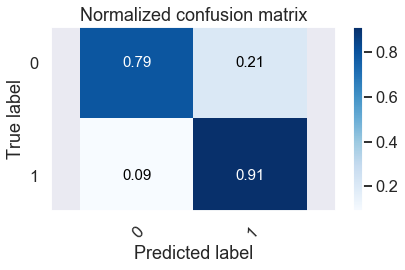

In [222]:
def plot_confusion_matrix(y_true, y_pred, classes=np.array([0,1]), normalize=True, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    ax.axis('equal')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout();
    return ax, cm

cmg = plot_confusion_matrix(ytestg, df_gloveb["pred"])

tn=cmg[1][0][0]
fp=cmg[1][0][1]
fn=cmg[1][1][0]
tp=cmg[1][1][1]

acc = (tn+tp) / (tn+tp+fp+fn)
prec = (tp) / (tp+fp)
rec = (tp) / (tp+fn)
print("Accuracy:", acc, "Precision:", prec, "Recall:",rec )

plt.grid(b=None)
plt.rcParams.update({'font.size': 15})

Normalized confusion matrix
Accuracy: 0.7833970997776825 Precision: 0.7366073767753285 Recall: 0.8822733978036388


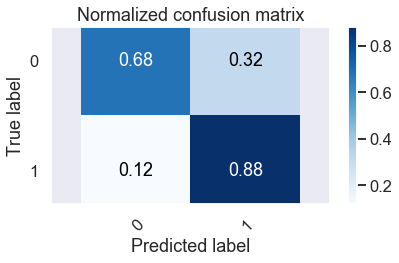

In [219]:
cmf1 = plot_confusion_matrix(ytestg, df_glovek["pred"])

tn=cmf1[1][0][0]
fp=cmf1[1][0][1]
fn=cmf1[1][1][0]
tp=cmf1[1][1][1]

acc = (tn+tp) / (tn+tp+fp+fn)
prec = (tp) / (tp+fp)
rec = (tp) / (tp+fn)
print("Accuracy:", acc, "Precision:", prec, "Recall:",rec )

plt.grid(b=None)
plt.rcParams.update({'font.size': 15})

Normalized confusion matrix
Accuracy: 0.8567013032845534 Precision: 0.8239875994919509 Recall: 0.9071873463366661


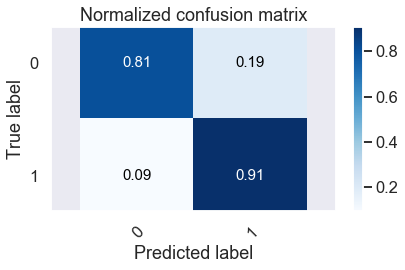

In [220]:
cmf1 = plot_confusion_matrix(ytest, df_fttxb["pred"])

tn=cmf1[1][0][0]
fp=cmf1[1][0][1]
fn=cmf1[1][1][0]
tp=cmf1[1][1][1]

acc = (tn+tp) / (tn+tp+fp+fn)
prec = (tp) / (tp+fp)
rec = (tp) / (tp+fn)
print("Accuracy:", acc, "Precision:", prec, "Recall:",rec )

plt.grid(b=None)
plt.rcParams.update({'font.size': 15})

Normalized confusion matrix
Accuracy: 0.7607215163964014 Precision: 0.7022925545629024 Recall: 0.9051385018849369


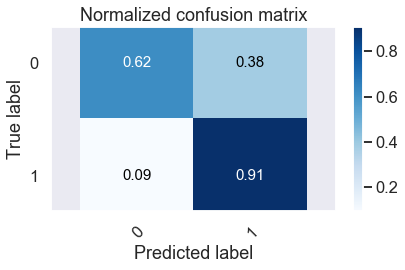

In [221]:
cmf1 = plot_confusion_matrix(ytest, df_fttxk["pred"])

tn=cmf1[1][0][0]
fp=cmf1[1][0][1]
fn=cmf1[1][1][0]
tp=cmf1[1][1][1]

acc = (tn+tp) / (tn+tp+fp+fn)
prec = (tp) / (tp+fp)
rec = (tp) / (tp+fn)
print("Accuracy:", acc, "Precision:", prec, "Recall:",rec )

plt.grid(b=None)
plt.rcParams.update({'font.size': 15})

In [223]:
print("Glove - Bidirectional AUC test: ", roc_aucgt)
print("Glove - Kim's Model AUC test: ", roc_aucgt1)
print('Fasttext - Bidirectional AUC test: ', roc_aucft)
print("Fasttext - Kim's Model AUC test: ", roc_aucft1)

Glove - Bidirectional AUC test:  0.9441364580651062
Glove - Kim's Model AUC test:  0.8910633287363572
Fasttext - Bidirectional AUC test:  0.9441253787066555
Fasttext - Kim's Model AUC test:  0.8843140030501659


#### AUC

In [ ]:
sns.set('talk', 'darkgrid', 'dark', font_scale=1) #rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

lw = 2
plt.figure()
#plt.plot(fprg, tprg, color='darkorange',
#         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot(fprgt, tprgt, label='%s ROC (area = %0.2f)' % ("Glove - B", roc_aucgt), color = "green")
plt.plot(fprgt1, tprgt1, label='%s ROC (area = %0.2f)' % ("Glove - KM", roc_aucgt1), color = "yellow")
plt.plot(fprft, tprft, label='%s ROC (area = %0.2f)' % ("fasttext - B", roc_aucft), color = "orange")
plt.plot(fprft1, tprft1, label='%s ROC (area = %0.2f)' % ("fasttext - KM", roc_aucft1), color = "purple")
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")

# I am saving the output as a PDF for easy exporting.
#plt.savefig('roc_auc.pdf', format = "pdf")

# Now I show the plot inline.
plt.show()

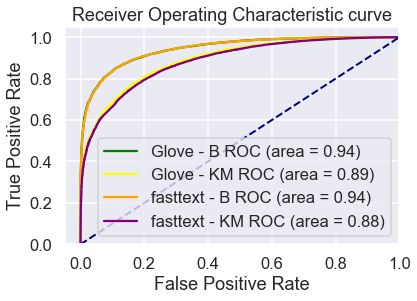

In [218]:
sns.set('talk', 'darkgrid', 'dark', font_scale=1) #rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

lw = 2
plt.figure()
#plt.plot(fprg, tprg, color='darkorange',
#         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot(fprgt, tprgt, label='%s ROC (area = %0.2f)' % ("Glove - B", roc_aucgt), color = "green")
plt.plot(fprgt1, tprgt1, label='%s ROC (area = %0.2f)' % ("Glove - KM", roc_aucgt1), color = "yellow")
plt.plot(fprft, tprft, label='%s ROC (area = %0.2f)' % ("fasttext - B", roc_aucft), color = "orange")
plt.plot(fprft1, tprft1, label='%s ROC (area = %0.2f)' % ("fasttext - KM", roc_aucft1), color = "purple")
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")

# I am saving the output as a PDF for easy exporting.
#plt.savefig('roc_auc.pdf', format = "pdf")

# Now I show the plot inline.
plt.show()

### Changing the parameters of the architectures using fasttext embeddings

In [ ]:
# This model was using 3 CNN instead of 4
loss31 = modelk31.history.history['loss']
val_loss31 = modelk31.history.history['val_loss']
epochs31 = range(1, len(loss31) + 1)
plt.figure(dpi=120)
plt.plot(epochs31, loss31, 'bo', label='Training loss')
plt.plot(epochs31, val_loss31, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


**Model Changing the filter sizes in the pararell layer (14,15,20)**

In [ ]:
# Filter sizes to use.
filter_sizes = (14,15,20) 

# Initialize
graph_in = Input(shape=(64, 300)) # will keep the input layer without any connections
convs = []
avgs = []

# This for stacks the layers. Inside each for, we build the sequence of layer. The command "append" adds
# that to the "conv" variable, which is simply a stack of convolutions.
for fsz in filter_sizes:
    conv = Conv1D(filters=128,
                  kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=1)(graph_in) # Note the (graph_in). This means "put this layer AFTER the graph_in layer.
                         #max looking for the very best variable, 
    pool = MaxPooling1D(pool_size=fsz)(conv) # Put this layer AFTER the convolution just created.connnect to the con
    flattenMax = Flatten()(pool) # Flatten the pooling layer.
    convs.append(flattenMax) # Append this to the convs object that saves the stack.
    
# Concatenate layers.
if len(filter_sizes)>1:
    out = Concatenate()(convs)
else:
    out = convs[0]

graph = Model(inputs=graph_in, outputs=out, name="graphModel")

graph.summary()

In [ ]:
# Final model
model = Sequential()
embedding_layer = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

model.add(embedding_layer)

# Now we add our graph model
model.add(graph)

# Add a few layers
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# adam = Adam(clipnorm=.1)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model.fit(Xtrain, ytrain, validation_split=1/3, epochs=50, batch_size=32)

In [ ]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Model changing the filter sizes of the pararell CNN to (4,4,4)**

In [ ]:
# Filter sizes to use.
filter_sizes3 = (4,4,4) 

# Initialize. 
graph_in3 = Input(shape=(88, 300)) # will keep the input layer without any connections
convs3 = []
avgs3 = []

# This for stacks the layers. Inside each for, we build the sequence of layer. The command "append" adds
# that to the "conv" variable, which is simply a stack of convolutions.
for fsz in filter_sizes3:
    conv = Conv1D(filters=64,
                  kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=2)(graph_in3) # Note the (graph_in). This means "put this layer AFTER the graph_in layer.
                         #max looking for the very best variable, 
    pool = MaxPooling1D(pool_size=fsz)(conv) # Put this layer AFTER the convolution just created.connnect to the con
    #flattenMax = Flatten()(pool) # Flatten the pooling layer.
    convs3.append(pool) # Append this to the convs object that saves the stack.
    
# Concatenate layers.
if len(filter_sizes3)>1:
    out = Concatenate()(convs3)
else:
    out = convs3[0]

graph3 = Model(inputs=graph_in3, outputs=out, name="graphModel")

graph3.summary()

In [ ]:
modelk3 = Sequential()
embedding_layerk3 = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

modelk3.add(embedding_layerk3)
modelk3.add(Dropout(0.6))
# Now we add our graph model
modelk3.add(graph3)

# Add a few layers

modelk3.add(Flatten())
modelk3.add(Dense(64, activation='relu'))
modelk3.add(Dropout(0.5))
modelk3.add(Dense(64, activation = 'relu'))
modelk3.add(Dropout(0.5))
modelk3.add(Dense(1))
modelk3.add(Dense(1, activation='sigmoid'))

# adam = Adam(clipnorm=.1)
modelk3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
modelk3.fit(Xtrain, ytrain, validation_split=0.3, epochs=50, batch_size=32, verbose=1)

In [ ]:
loss = modelk3.history.history['loss']
val_loss = modelk3.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(dpi=120)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


**Model changing the filter sizes of the pararell CNN to (4,5,6)**

In [ ]:
# Filter sizes to use.
filter_sizes4 = (4,5,6)

# Initialize
graph_in4 = Input(shape=(88, 300)) # will keep the input layer without any connections
convs4 = []
avgs4 = []

# This for stacks the layers. Inside each for, we build the sequence of layer. The command "append" adds
# that to the "conv" variable, which is simply a stack of convolutions.
for fsz in filter_sizes4:
    conv = Conv1D(filters=32,
                  kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=2)(graph_in4) # Note the (graph_in). This means "put this layer AFTER the graph_in layer.
                         #max looking for the very best variable, 
    pool = MaxPooling1D(pool_size=fsz)(conv) # Put this layer AFTER the convolution just created.connnect to the con
    #flattenMax = Flatten()(pool) # Flatten the pooling layer.
    convs4.append(pool) # Append this to the convs object that saves the stack.
    
# Concatenate layers.
if len(filter_sizes4)>1:
    out = Concatenate()(convs4)
else:
    out = convs4[0]

graph4 = Model(inputs=graph_in4, outputs=out, name="graphModel")

graph4.summary()

In [ ]:
modelk4 = Sequential()
embedding_layerk4 = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

modelk4.add(embedding_layerk3)
modelk4.add(Dropout(0.6))
modelk4.add(BatchNormalization())
# Now we add our graph model
modelk4.add(graph4)

# Add a few layers

modelk4.add(Flatten())
modelk4.add(Dense(64, activation='relu'))
modelk4.add(Dropout(0.5))
modelk4.add(Dense(64, activation = 'relu'))
modelk4.add(Dropout(0.5))
modelk4.add(Dense(1, activation='sigmoid'))

# adam = Adam(clipnorm=.1)
modelk4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
modelk4.fit(Xtrain, ytrain, validation_split=0.3, epochs=100, batch_size=32, verbose=1)

In [ ]:
loss1 = modelk4.history.history['loss']
val_loss1 = modelk4.history.history['val_loss']
epochs1 = range(1, len(loss1) + 1)
plt.figure(dpi=120)
plt.plot(epochs1, loss1, 'bo', label='Training loss')
plt.plot(epochs1, val_loss1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Normalization makes it worst

**Model with parallel filter sizes of 4,4,4 and adding a CNN with filter of 128**

In [ ]:
# Filter sizes to use.
filter_sizes5 = (4,4,4)

# Initialize.
graph_in5 = Input(shape=(88, 300)) # will keep the input layer without any connections
convs5 = []
avgs5 = []

# This for stacks the layers. Inside each for, we build the sequence of layer. The command "append" adds
# that to the "conv" variable, which is simply a stack of convolutions.
for fsz in filter_sizes5:
    conv = Conv1D(filters=32,
                  kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=2)(graph_in5) # Note the (graph_in). This means "put this layer AFTER the graph_in layer.
                         #max looking for the very best variable, 
    pool = MaxPooling1D(pool_size=fsz)(conv) # Put this layer AFTER the convolution just created.connnect to the con
    #flattenMax = Flatten()(pool) # Flatten the pooling layer.
    convs5.append(pool) # Append this to the convs object that saves the stack.
    
# Concatenate layers.
if len(filter_sizes5)>1:
    out = Concatenate()(convs5)
else:
    out = convs5[0]

graph5 = Model(inputs=graph_in5, outputs=out, name="graphModel")

graph5.summary()

In [ ]:
modelk5 = Sequential()
embedding_layerk5 = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

modelk5.add(embedding_layerk5)
modelk5.add(Dropout(0.6))
# Now we add our graph model
modelk5.add(graph5)

modelk5.add(Conv1D(filters=128,           # How many filters to calculate. 128 sentences of length 3
                 kernel_size=3,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))
# Add a few layers

modelk5.add(Flatten())
modelk5.add(Dense(128, activation='relu'))
modelk5.add(Dropout(0.5))
modelk5.add(Dense(128, activation = 'relu'))
modelk5.add(Dropout(0.5))
modelk5.add(Dense(1, activation='sigmoid'))

# adam = Adam(clipnorm=.1)
modelk5.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
modelk5.fit(Xtrain, ytrain, validation_split=0.3, epochs=100, batch_size=32, verbose=1)

In [ ]:
loss2 = modelk5.history.history['loss']
val_loss2 = modelk5.history.history['val_loss']
epochs2 = range(1, len(loss2) + 1)
plt.figure(dpi=120)
plt.plot(epochs2, loss2, 'bo', label='Training loss')
plt.plot(epochs2, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Model with BatchNormalization and 3 CNNs with 128 as filter size**

In [ ]:
model3 = Sequential()
embedding_layer = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

model3.add(embedding_layer)
model3.add(Dropout(0.6))
model3.add(BatchNormalization())
model3.add(Conv1D(filters=128,           # How many filters to calculate. 128 sentences of length 3
                 kernel_size=3,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))


model3.add(Conv1D(filters=128,           # How many filters to calculate. 128 sentences of length 3
                 kernel_size=3,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))


model3.add(Conv1D(filters=128,           # How many filters to calculate. 128 sentences of length 3
                 kernel_size=3,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))

model3.add(GlobalMaxPool1D())

model3.add(Flatten())
model3.add(Dense(128, activation = 'relu'))
model3.add(Dropout(0.6))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.6))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data

In [ ]:
model3.fit(Xtrain, ytrain, validation_split=0.3, epochs=100, batch_size=32, verbose=1)

In [ ]:
loss3 = model3.history.history['loss']
val_loss3 = model3.history.history['val_loss']
epochs3 = range(1, len(loss3) + 1)
plt.figure(dpi=120)
plt.plot(epochs3, loss3, 'bo', label='Training loss')
plt.plot(epochs3, val_loss3, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Model with BatchNormalization and 3 CNNs with 128 as filter size**

In [ ]:
model4 = Sequential()
embedding_layer = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

model4.add(embedding_layer)
model4.add(Dropout(0.6))
#model3.add(BatchNormalization())
model4.add(Conv1D(filters=64,           # How many filters to calculate.
                 kernel_size=3,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))


model4.add(Conv1D(filters=64,           # How many filters to calculate.
                 kernel_size=3,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))


model4.add(Conv1D(filters=64,           # How many filters to calculate.
                 kernel_size=3,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))

model4.add(Conv1D(filters=64,           # How many filters to calculate.
                 kernel_size=3,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))

model4.add(GlobalMaxPool1D())

model4.add(Flatten())
model4.add(Dense(128, activation = 'relu'))
model4.add(Dropout(0.6))
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.6))
model4.add(Dense(1, activation='sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data

In [ ]:
model4.fit(Xtrain, ytrain, validation_split=0.3, epochs=100, batch_size=32, verbose=1)

In [ ]:
loss4 = model4.history.history['loss']
val_loss4 = model4.history.history['val_loss']
epochs4 = range(1, len(loss4) + 1)
plt.figure(dpi=120)
plt.plot(epochs4, loss4, 'bo', label='Training loss')
plt.plot(epochs4, val_loss4, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Model with BatchNormalization and 3 CNNs with 128 as filter size adding a Max Pooling**

In [ ]:
model5 = Sequential()
embedding_layer = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

model5.add(embedding_layer)
model5.add(Dropout(0.6))
model5.add(BatchNormalization())
model5.add(Conv1D(filters=128,           # How many filters to calculate. 128 sentences of length 3
                 kernel_size=3,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))

#model5.add(BatchNormalization())
model5.add(Conv1D(filters=128,           # How many filters to calculate. 128 sentences of length 3
                 kernel_size=3,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))
model.add(MaxPooling1D(pool_size = 2))

model5.add(Conv1D(filters=128,           # How many filters to calculate. 128 sentences of length 3
                 kernel_size=3,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))

model5.add(Conv1D(filters=128,           # How many filters to calculate. 128 sentences of length 3
                 kernel_size=3,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))

model5.add(GlobalMaxPool1D())

model5.add(Flatten())
model5.add(Dense(128, activation = 'relu'))
model5.add(Dropout(0.6))
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.6))
model5.add(Dense(1, activation='sigmoid'))
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data

In [ ]:
model5.fit(Xtrain, ytrain, validation_split=0.3, epochs=100, batch_size=32, verbose=1)

In [ ]:
loss5 = model5.history.history['loss']
val_loss5 = model5.history.history['val_loss']
epochs5 = range(1, len(loss5) + 1)
plt.figure(dpi=120)
plt.plot(epochs5, loss5, 'bo', label='Training loss')
plt.plot(epochs5, val_loss5, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Model with BatchNormalization and 3 CNNs changing kernel size to (5, 4, 3)**

In [ ]:
model6 = Sequential()
embedding_layer = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

model6.add(embedding_layer)
model6.add(Dropout(0.6))
model6.add(BatchNormalization())
model6.add(Conv1D(filters=64,           # How many filters to calculate.
                 kernel_size=5,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))

#model5.add(BatchNormalization())
model6.add(Conv1D(filters=64,           # How many filters to calculate.
                 kernel_size=5,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))


model6.add(Conv1D(filters=128,           # How many filters to calculate.
                 kernel_size=4,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))

model6.add(Conv1D(filters=128,           # How many filters to calculate.
                 kernel_size=4,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))

model6.add(GlobalMaxPool1D())

model6.add(Flatten())
model6.add(Dense(128, activation = 'relu'))
model6.add(Dropout(0.6))
model6.add(Dense(128, activation='relu'))
model6.add(Dropout(0.6))
model6.add(Dense(1, activation='sigmoid'))
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data

In [ ]:
model6.fit(Xtrain, ytrain, validation_split=0.3, epochs=100, batch_size=32, verbose=1)

In [ ]:
loss6 = model6.history.history['loss']
val_loss6 = model6.history.history['val_loss']
epochs6 = range(1, len(loss6) + 1)
plt.figure(dpi=120)
plt.plot(epochs6, loss6, 'bo', label='Training loss')
plt.plot(epochs6, val_loss6, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Changing kernel filters (64, 128, 128)**

In [ ]:
model7 = Sequential()
embedding_layer = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

model7.add(embedding_layer)
model7.add(Dropout(0.6))
model7.add(BatchNormalization())
model7.add(Conv1D(filters=64,           # How many filters to calculate.
                 kernel_size=5,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))

#model5.add(BatchNormalization())
model7.add(Conv1D(filters=64,           # How many filters to calculate.
                 kernel_size=5,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))


model7.add(Conv1D(filters=128,           # How many filters to calculate.
                 kernel_size=4,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))

model7.add(Conv1D(filters=128,           # How many filters to calculate.
                 kernel_size=4,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))

model7.add(GlobalMaxPool1D())

model7.add(Flatten())
model7.add(Dense(128, activation = 'relu'))
model7.add(Dropout(0.6))
model7.add(Dense(128, activation='relu'))
model7.add(Dropout(0.6))
model7.add(Dense(1, activation='sigmoid'))
model7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data

In [ ]:
model7.fit(Xtrain, ytrain, validation_split=0.3, epochs=100, batch_size=32, verbose=1)

In [ ]:
loss7 = model7.history.history['loss']
val_loss7 = model7.history.history['val_loss']
epochs7 = range(1, len(loss7) + 1)
plt.figure(dpi=120)
plt.plot(epochs7, loss7, 'bo', label='Training loss')
plt.plot(epochs7, val_loss7, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Kim's Model changing the filter sizes**

In [ ]:
# Filter sizes to use.
filter_sizes = (3,4,4,5,6) 

# Initialize.
graph_in = Input(shape=(88, 300)) # will keep the input layer without any connections
convs = []
avgs = []

# This for stacks the layers. Inside each for, we build the sequence of layer. The command "append" adds
# that to the "conv" variable, which is simply a stack of convolutions.
for fsz in filter_sizes:
    conv = Conv1D(filters=32,
                  kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=1)(graph_in) # Note the (graph_in). This means "put this layer AFTER the graph_in layer.
                         #max looking for the very best variable, 
    pool = MaxPooling1D(pool_size=88 - fsz + 1)(conv) # Put this layer AFTER the convolution just created.connnect to the con
    flattenMax = Flatten()(pool) # Flatten the pooling layer.
    convs.append(flattenMax) # Append this to the convs object that saves the stack.
    
# Concatenate layers.
if len(filter_sizes)>1:
    out = Concatenate()(convs)
else:
    out = convs[0]

graph = Model(inputs=graph_in, outputs=out, name="graphModel")

graph.summary()

In [ ]:
# Final model
model = Sequential()
embedding_layer = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

model.add(embedding_layer)
model.add(Dropout(0.5))
model7.add(BatchNormalization())
# Now we add our graph model

#model.add(Flatten())
model.add(graph)





model.add(Dense(32, activation='relu'))

# Add a few layers
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# adam = Adam(clipnorm=.1)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
model.fit(Xtrain, ytrain, validation_split=0.3, epochs=100, batch_size=32, verbose=1)

In [ ]:
loss8 = model.history.history['loss']
val_loss8 = model.history.history['val_loss']
epochs8 = range(1, len(loss8) + 1)
plt.figure(dpi=120)
plt.plot(epochs8, loss8, 'bo', label='Training loss')
plt.plot(epochs8, val_loss8, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Filter sizes to use.
filter_sizes = (4,5,6) 

# Initialize.
graph_in2 = Input(shape=(88, 300)) # will keep the input layer without any connections
convs2 = []
avgs2 = []

# This for stacks the layers. Inside each for, we build the sequence of layer. The command "append" adds
# that to the "conv" variable, which is simply a stack of convolutions.
for fsz in filter_sizes:
    conv = Conv1D(filters=32,
                  kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=1)(graph_in2) # Note the (graph_in). This means "put this layer AFTER the graph_in layer.
                         #max looking for the very best variable, 
    pool = MaxPooling1D(pool_size=fsz-2)(conv) # Put this layer AFTER the convolution just created.connnect to the con
    flattenMax = Flatten()(pool) # Flatten the pooling layer.
    convs2.append(flattenMax) # Append this to the convs object that saves the stack.
    
# Concatenate layers.
if len(filter_sizes)>1:
    out = Concatenate()(convs2)
else:
    out = convs2[0]

graph2 = Model(inputs=graph_in2, outputs=out, name="graphModel")

graph2.summary()

In [ ]:
# Final model
model9 = Sequential()
embedding_layer = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

model9.add(embedding_layer)
model9.add(Dropout(0.5))

# Now we add our graph model

#model.add(Flatten())
model9.add(graph2)


model9.add(Dense(32, activation='relu'))

# Add a few layers
model9.add(Dense(32, activation='relu'))
model9.add(Dropout(0.5))
model9.add(Dense(1, activation='sigmoid'))

# adam = Adam(clipnorm=.1)
model9.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
model9.fit(Xtrain, ytrain, validation_split=0.3, epochs=50, batch_size=16, verbose=1)

In [ ]:
loss9 = model9.history.history['loss']
val_loss9 = model9.history.history['val_loss']
epochs9 = range(1, len(loss9) + 1)
plt.figure(dpi=120)
plt.plot(epochs9, loss9, 'bo', label='Training loss')
plt.plot(epochs9, val_loss9, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model10 = Sequential()
embedding_layer = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

model10.add(embedding_layer)
model10.add(Dropout(0.3))
#model10.add(BatchNormalization())
model10.add(Conv1D(filters=128,           # How many filters to calculate. 128 sentences of length 5
                 kernel_size=5,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))

#model5.add(BatchNormalization())
model10.add(Conv1D(filters=128,           # How many filters to calculate. 128 sentences of length 5
                 kernel_size=5,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))


model10.add(Conv1D(filters=128,           # How many filters to calculate. 128 sentences of length 3
                 kernel_size=4,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))

model10.add(Conv1D(filters=128,           # How many filters to calculate. 128 sentences of length 4
                 kernel_size=4,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))

model10.add(GlobalMaxPool1D())

model10.add(Flatten())
model10.add(Dense(128, activation = 'relu'))
model10.add(Dropout(0.3))
model10.add(Dense(128, activation='relu'))
model10.add(Dropout(0.3))
model10.add(Dense(1, activation='sigmoid'))
model10.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data

In [ ]:
model10.fit(Xtrain, ytrain, validation_split=0.3, epochs=100, batch_size=32, verbose=1)

In [ ]:
loss10 = model10.history.history['loss']
val_loss10 = model10.history.history['val_loss']
epochs10 = range(1, len(loss10) + 1)
plt.figure(dpi=120)
plt.plot(epochs10, loss10, 'bo', label='Training loss')
plt.plot(epochs10, val_loss10, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# model withou

In [ ]:
model11 = Sequential()
embedding_layer = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False) 
model11.add(embedding_layer)

model11.add(Bidirectional(CuDNNLSTM(64, return_sequences=True)))

model11.add(GlobalMaxPooling1D())
model11.add(Dropout(0.5))
model11.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model11.add(Dense(128, activation='relu'))
model11.add(Dropout(0.5))
model11.add(Dense(1, activation='sigmoid'))

model11.compile(optimizer=optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model11.fit(Xtrain, ytrain, validation_split=0.3, epochs=50, batch_size=32, verbose=1)

In [ ]:
loss11 = model11.history.history['loss']
val_loss11 = model11.history.history['val_loss']
epochs11 = range(1, len(loss11) + 1)
plt.figure(dpi=120)
plt.plot(epochs11, loss11, 'bo', label='Training loss')
plt.plot(epochs11, val_loss11, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Structure 2
model_ft = Sequential()
embedding_layer = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

model_ft.add(embedding_layer)
model_ft.add(Dropout(0.4))

model_ft.add(Bidirectional(GRU(64, return_sequences=True)))

model_ft.add(Conv1D(filters=64,           # How many filters to calculate.
                 kernel_size=5,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=3))

model_ft.add(Conv1D(filters=64,           # How many filters to calculate.
                 kernel_size=4,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))
model_ft.add(GlobalMaxPool1D())

model_ft.add(Dense(64, activation='relu'))
model_ft.add(Dense(64, activation='relu'))
model_ft.add(Dropout(0.4))
model_ft.add(Dense(1, activation='sigmoid'))
model_ft.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data
model_ft.fit(data, np.array(labels), validation_split=0.3, epochs = 50)

In [ ]:
loss_ft = model_ft.history.history['loss']
val_loss_ft = model_ft.history.history['val_loss']
epochs_ft = range(1, len(loss_ft) + 1)
plt.figure(dpi=120)
plt.plot(epochs_ft, loss_ft, 'bo', label='Training loss')
plt.plot(epochs_ft, val_loss_ft, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Changing the parameters of the architectures using Glove embedding

**This model used different only 3 filters in the graph model**

In [ ]:
#This model used different only 3 filters in the hraph model
modelg = Sequential()
embedding_layerg = Embedding(len(embedding_glove),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_glove],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

modelg.add(embedding_layerg)
modelg.add(Dropout(0.6))
# Now we add our graph model
modelg.add(graph3)

# Add a few layers

modelg.add(Flatten())
modelg.add(Dense(64, activation='relu'))
modelg.add(Dropout(0.5))
modelg.add(Dense(64, activation = 'relu'))
modelg.add(Dropout(0.5))
modelg.add(Dense(1))
modelg.add(Dense(1, activation='sigmoid'))

# adam = Adam(clipnorm=.1)
modelg.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
modelg.fit(Xtraing, ytraing, validation_split=0.3, epochs=100, batch_size=32, verbose=1)

In [ ]:
loss_g = modelg.history.history['loss']
val_lossg = modelg.history.history['val_loss']
epochs_g = range(1, len(loss_g) + 1)
plt.figure(dpi=120)
plt.plot(epochs_g, loss_g, 'bo', label='Training loss')
plt.plot(epochs_g, val_lossg, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### This model used in the graph model 4 filters of size 4

In [ ]:

modelg1 = Sequential()
embedding_layerg = Embedding(len(embedding_glove),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_glove],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

modelg1.add(embedding_layerg)
modelg1.add(Dropout(0.5))
# Now we add our graph model
modelg1.add(graph3)


modelg1.add(Conv1D(filters=64,           # How many filters to calculate.
                 kernel_size=4,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))
# Add a few layers

modelg1.add(Flatten())
modelg1.add(Dense(64, activation='relu'))
modelg1.add(Dropout(0.5))
modelg1.add(Dense(64, activation = 'relu'))
modelg1.add(Dropout(0.5))
modelg1.add(Dense(1))
modelg1.add(Dense(1, activation='sigmoid'))

# adam = Adam(clipnorm=.1)
modelg1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
modelg1.fit(Xtraing, ytraing, validation_split=0.3, epochs=100, batch_size=32, verbose=1)

In [ ]:
loss_g1 = modelg1.history.history['loss']
val_lossg1 = modelg1.history.history['val_loss']
epochs_g1 = range(1, len(loss_g1) + 1)
plt.figure(dpi=120)
plt.plot(epochs_g1, loss_g1, 'bo', label='Training loss')
plt.plot(epochs_g1, val_lossg1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Bidirectional model removing dense layer**

In [ ]:
model_glove = Sequential()
embedding_layerg = Embedding(len(embedding_glove),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_glove],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

model_glove.add(embedding_layerg)
model_glove.add(Dropout(0.5))

model_glove.add(Bidirectional(GRU(64, return_sequences=True)))

model_glove.add(Conv1D(filters=64,           # How many filters to calculate.
                 kernel_size=4,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))
model_glove.add(Conv1D(filters=64,           # How many filters to calculate.
                 kernel_size=4,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))
model_glove.add(GlobalMaxPool1D())

model_glove.add(Dense(64, activation='relu'))
model_glove.add(Dropout(0.5))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data
model_glove.fit(Xtraing, ytraing, validation_split=0.3, epochs=50, batch_size=32, verbose=1)

In [ ]:
model_glove.fit(Xtraing, ytraing, validation_split=0.3, epochs=50, batch_size=256, verbose=1)

In [ ]:
loss_g2 = model_glove.history.history['loss']
val_lossg2 = model_glove.history.history['val_loss']
epochs_g2 = range(1, len(loss_g2) + 1)
plt.figure(dpi=120)
plt.plot(epochs_g2, loss_g2, 'bo', label='Training loss')
plt.plot(epochs_g2, val_lossg2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
modelk31g = Sequential()
embedding_layerk31g = Embedding(len(embedding_glove),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_glove],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

modelk31g.add(embedding_layerk31g)
modelk31g.add(Dropout(0.6))
# Now we add our graph model
modelk31g.add(graph31)

# Add a few layers

modelk31g.add(Flatten())
modelk31g.add(Dense(64, activation='relu'))
modelk31g.add(Dropout(0.5))
modelk31g.add(Dense(64, activation = 'relu'))
modelk31g.add(Dropout(0.5))
modelk31g.add(Dense(1))
modelk31g.add(Dense(1, activation='sigmoid'))

# adam = Adam(clipnorm=.1)
modelk31g.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

In [ ]:
modelk31g.fit(Xtraing, ytraing, validation_split=0.3, epochs=100, batch_size=32, verbose=1)

In [ ]:
modelk31g.summary()

In [ ]:
lossk31g = modelk31g.history.history['loss']
valk31g = modelk31g.history.history['val_loss']
epochsk31g = range(1, len(lossk31g) + 1)
plt.figure(dpi=120)
plt.plot(epochsk31g, lossk31g, 'bo', label='Training loss')
plt.plot(epochsk31g, valk31g, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Model that used kims model with 4 filters of size 4 and outside of this layer 3 dense layers were applied**

In [ ]:
# Filter sizes to use.
filter_sizes312 = (4,4,4,4)

# Initialize.
graph_in312 = Input(shape=(88, 300)) # will keep the input layer without any connections
convs312 = []
avgs312 = []

# This for stacks the layers. Inside each for, we build the sequence of layer. The command "append" adds
# that to the "conv" variable, which is simply a stack of convolutions.
for fsz in filter_sizes312:
    conv = Conv1D(filters=32,
                  kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=2)(graph_in312) # Note the (graph_in). This means "put this layer AFTER the graph_in layer.
                         #max looking for the very best variable, 
    pool = MaxPooling1D(pool_size=fsz)(conv) # Put this layer AFTER the convolution just created.connnect to the con
    #flattenMax = Flatten()(pool) # Flatten the pooling layer.
    convs312.append(pool) # Append this to the convs object that saves the stack.
    
# Concatenate layers.
if len(filter_sizes312)>1:
    out = Concatenate()(convs312)
else:
    out = convs312[0]

graph312 = Model(inputs=graph_in312, outputs=out, name="graphModel")

graph312.summary()

In [ ]:
modelk312g = Sequential()
embedding_layerk312g = Embedding(len(embedding_glove),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_glove],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

modelk312g.add(embedding_layerk312g)
modelk312g.add(Dropout(0.6))
# Now we add our graph model
modelk312g.add(graph312)

# Add a few layers

modelk312g.add(Flatten())
modelk312g.add(Dense(64, activation='relu'))
modelk312g.add(Dropout(0.5))
modelk312g.add(Dense(64, activation='relu'))
modelk312g.add(Dropout(0.5))
modelk312g.add(Dense(64, activation = 'relu'))
modelk312g.add(Dropout(0.5))
modelk312g.add(Dense(1))
modelk312g.add(Dense(1, activation='sigmoid'))

# adam = Adam(clipnorm=.1)
modelk312g.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

In [ ]:
modelk312g.fit(Xtraing, ytraing, validation_split=0.3, epochs=50, batch_size=32, verbose=1)

In [ ]:
lossk312g = modelk312g.history.history['loss']
valk312g = modelk312g.history.history['val_loss']
epochsk312g = range(1, len(lossk312g) + 1)
plt.figure(dpi=120)
plt.plot(epochsk312g, lossk312g, 'bo', label='Training loss')
plt.plot(epochsk312g, valk312g, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Bidirectional Model with only 1 Convolutional Layer**

In [ ]:
# Model using Bidirectional with only one convolutional layer
model_glove = Sequential()
embedding_layerg = Embedding(len(embedding_glove),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_glove],    # The weights we just calculated
                            input_length=88,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

model_glove.add(embedding_layerg)
model_glove.add(Dropout(0.5))

model_glove.add(Bidirectional(GRU(64, return_sequences=True)))

model_glove.add(Conv1D(filters=64,           # How many filters to calculate.
                 kernel_size=4,         # How many words to calculate per filter.
                 padding='valid',       # Add padding? pre,or pos padd # pre padding at the end 
                 activation='relu',     # What activation to use?
                 strides=2))
model_glove.add(GlobalMaxPool1D())

model_glove.add(Dense(64, activation='relu'))
model_glove.add(Dropout(0.5))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data


In [ ]:
lossk31g2 = modelk31g2.history.history['loss']
valk31g2 = modelk31g2.history.history['val_loss']
epochsk31g2 = range(1, len(lossk31g2) + 1)
plt.figure(dpi=120)
plt.plot(epochsk31g2, lossk31g2, 'bo', label='Training loss')
plt.plot(epochsk31g2, valk31g2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()